# Preprocessing and clustering scATAC PBMCs using Scanpy and scOpen

In this tutorial, we will show how to use scOpen and (epi)Scanpy to analyze scATAC-seq. The data is from epiScanpy [tutorial](https://nbviewer.jupyter.org/github/colomemaria/epiScanpy/blob/master/docs/tutorials/Buenrostro_PBMC_data_processing.html) and it consists of ~3000 human PBMCs. Cell labels are available for validation.

In [1]:
!mkdir -p data
!wget https://www.dropbox.com/s/cwlaaxl70t27tb2/data_tutorial_buenrostro.tar.gz?dl=0 -O data/data_tutorial_buenrostro.tar.gz
!cd data; tar -xzf data_tutorial_buenrostro.tar.gz
!mkdir -p write

--2021-07-21 21:57:31--  https://www.dropbox.com/s/cwlaaxl70t27tb2/data_tutorial_buenrostro.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/cwlaaxl70t27tb2/data_tutorial_buenrostro.tar.gz [following]
--2021-07-21 21:57:32--  https://www.dropbox.com/s/raw/cwlaaxl70t27tb2/data_tutorial_buenrostro.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc33b13bb1f482055d19889f3f4f.dl.dropboxusercontent.com/cd/0/inline/BSsLnhLfgasIa52BmZ4bR5J26DH4fEfzR7VKmqPnfnAifqgPFe_eq6ve0cDiYQM2gFpxsGHEBDOo8bFSQC014gNfBNoMT9Y0p_r6QiONBmDkhZ7RGLE3aL-03ysFQmKSQmC6b-frszULMn4dkkh9wa5I/file# [following]
--2021-07-21 21:57:32--  https://uc33b13bb1f482055d19889f3f4f.dl.dropboxusercontent.com/cd/0/inline/BSsLnhLfgasIa52BmZ4bR5J26

In [2]:
## load library
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import episcanpy.api as epi
import scopen

In [3]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')

In [4]:
results_file = 'write/buenrostro_pbmc.h5ad'  # the file that will store the analysis results

## Load the data

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5 file format: .h5ad.

In [5]:
adata = ad.read('data/data_tutorial_buenrostro/all_buenrostro_bulk_peaks.h5ad')
adata

AnnData object with n_obs × n_vars = 2034 × 491436
    obs: 'batch', 'cell_name'

In [6]:
# display information stored in adata.obs
adata.obs

batch  \
BM1077-MPP-Frozen-160105-1.dedup.st.bam                0   
singles-20160726-scATAC-BM1137-GMP3high-HYC-88....     0   
singles-160808-scATAC-BM1137-GMP2mid-LS-65.dedu...     0   
singles-BM0828-LMPP-frozen-151105-20.dedup.st.bam      0   
singles-160819-BM1137-CMP-LS-95.dedup.st.bam           0   
...                                                  ...   
BM1077-LMPP-Frozen-160107-40.dedup.st.bam              1   
BM1077-MPP-Frozen-160105-74.dedup.st.bam               1   
singles-BM1214-GMP-160421-9.dedup.st.bam               1   
singles-BM0828-LMPP-frozen-151105-62.dedup.st.bam      1   
singles-BM0828-MEP-160420-43.dedup.st.bam              1   

                                                                                         cell_name  
BM1077-MPP-Frozen-160105-1.dedup.st.bam                                 BM1077-MPP-Frozen-160105-1  
singles-20160726-scATAC-BM1137-GMP3high-HYC-88....  singles-20160726-scATAC-BM1137-GMP3high-HYC-88  
singles-160808-scATAC-BM1137-GMP2mid-LS-65.dedu...      singles-160808-scATAC-BM1137-GMP2mid-LS-65  
singles-BM0828-LMPP-frozen-151105-20.dedup.st.bam             singles-BM0828-LMPP-frozen-151105-20  
singles-160819-BM1137-CMP-LS-95.dedup.st.bam                       singles-160819-BM1137-CMP-LS-95  
...                                                                                            ...  
BM1077-LMPP-Frozen-160107-40.dedup.st.bam                             BM1077-LMPP-Frozen-160107-40  
BM1077-MPP-Frozen-160105-74.dedup.st.bam                               BM1077-MPP-Frozen-160105-74  
singles-BM1214-GMP-160421-9.dedup.st.bam                               singles-BM1214-GMP-160421-9  
singles-BM0828-LMPP-frozen-151105-62.dedup.st.bam             singles-BM0828-LMPP-frozen-151105-62  
singles-BM0828-MEP-160420-43.dedup.st.bam                             singles-BM0828-MEP-160420-43  

[2034 rows x 2 columns]

In [7]:
# checking the variable names (bulk peaks coordinates)
print(adata.var_names)

Index(['chr1_10279_10779', 'chr1_13252_13752', 'chr1_16019_16519',
       'chr1_29026_29526', 'chr1_96364_96864', 'chr1_115440_115940',
       'chr1_237535_238035', 'chr1_240811_241311', 'chr1_540469_540969',
       'chr1_713909_714409',
       ...
       'chrX_154822578_154823078', 'chrX_154840821_154841321',
       'chrX_154841449_154841949', 'chrX_154841956_154842456',
       'chrX_154842517_154843017', 'chrX_154862057_154862557',
       'chrX_154870909_154871409', 'chrX_154880741_154881241',
       'chrX_154891824_154892324', 'chrX_154896342_154896842'],
      dtype='object', name='index', length=491436)


## Extract the FACs information from the file names

In [8]:
adata.obs['facs_label'] = ['MEP' if 'MEP' in line else line.split('.bam')[0].lstrip('singles-').split('BM')[-1].split('-')[1] for line in adata.obs['cell_name'].tolist()]
adata

AnnData object with n_obs × n_vars = 2034 × 491436
    obs: 'batch', 'cell_name', 'facs_label'

## Load the additional metadata

In [9]:
!head 'data/data_tutorial_buenrostro/metadata.tsv'

label	cell_type
BM1077-CLP-Frozen-160106-13	CLP
BM1077-CLP-Frozen-160106-14	CLP
BM1077-CLP-Frozen-160106-2	CLP
BM1077-CLP-Frozen-160106-21	CLP
BM1077-CLP-Frozen-160106-27	CLP
BM1077-CLP-Frozen-160106-3	CLP
BM1077-CLP-Frozen-160106-36	CLP
BM1077-CLP-Frozen-160106-42	CLP
BM1077-CLP-Frozen-160106-44	CLP


In [10]:
# format the cell names to match the metadata file
adata.obs_names = [x.split('/')[-1].split('.dedup.st.bam')[0] for x in adata.obs_names.tolist()]
adata.obs_names

Index(['BM1077-MPP-Frozen-160105-1',
       'singles-20160726-scATAC-BM1137-GMP3high-HYC-88',
       'singles-160808-scATAC-BM1137-GMP2mid-LS-65',
       'singles-BM0828-LMPP-frozen-151105-20',
       'singles-160819-BM1137-CMP-LS-95', 'BM1077-MPP-Frozen-160105-36',
       'singles-20160726-scATAC-BM1214-CMP-LS-84',
       'BM1077-CMP-Frozen-160106-21', 'singles-BM0106-HSC-SIM-160219-36',
       'singles-BM1214-GMP-160421-60',
       ...
       'singles-160822-BM1137-CMP-LS-91',
       'singles-BM0828-CMP-frozen-151118-69',
       'singles-20160617-scATAC-BM1214-CMP-LS-40',
       'singles-BM0828-GMP-151027-2',
       'singles-20160726-scATAC-BM1214-CMP-LS-19',
       'BM1077-LMPP-Frozen-160107-40', 'BM1077-MPP-Frozen-160105-74',
       'singles-BM1214-GMP-160421-9', 'singles-BM0828-LMPP-frozen-151105-62',
       'singles-BM0828-MEP-160420-43'],
      dtype='object', length=2034)

In [11]:
epi.pp.load_metadata(adata,
                     'data/data_tutorial_buenrostro/metadata.tsv',
                     separator='\t')
adata

AnnData object with n_obs × n_vars = 2034 × 491436
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type'

In [12]:
# check the 2 different annotation obtained
pd.crosstab(adata.obs['cell_type'], adata.obs['facs_label'])

facs_label  CLP  CMP  GMP  GMP1low  GMP2mid  GMP3high  HSC  LMPP  MCP  MEP  \
cell_type                                                                    
CLP          78    0    0        0        0         0    0     0    0    0   
CMP           0  502    0        0        0         0    0     0    0    0   
GMP           0    0  216       68       44        74    0     0    0    0   
HSC           0    0    0        0        0         0  347     0    0    0   
LMPP          0    0    0        0        0         0    0   160    0    0   
MEP           0    0    0        0        0         0    0     0    0  138   
MPP           0    0    0        0        0         0    0     0    0    0   
UNK           0    0    0        0        0         0    0     0    0    0   
mono          0    0    0        0        0         0    0     0    0    0   
pDC           0    0    0        0        0         0    0     0   73    0   

facs_label  MPP  UNK  mono  pDC  
cell_type                        
CLP           0    0     0    0  
CMP           0    0     0    0  
GMP           0    0     0    0  
HSC           0    0     0    0  
LMPP          0    0     0    0  
MEP           0    0     0    0  
MPP         142    0     0    0  
UNK           0   60     0    0  
mono          0    0    64    0  
pDC           0    0     0   68

## Load gene/transcript annotation

Download annotation file (the data are aligned on hg19)

In [13]:
!wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_19/gencode.v19.annotation.gtf.gz -O data/data_tutorial_buenrostro/gencode.v19.annotation.gtf.gz
!cd data/data_tutorial_buenrostro; gunzip gencode.v19.annotation.gtf

--2021-07-21 21:57:38--  ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_19/gencode.v19.annotation.gtf.gz
           => ‘data/data_tutorial_buenrostro/gencode.v19.annotation.gtf.gz’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.197.74
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.197.74|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/gencode/Gencode_human/release_19 ... done.
==> SIZE gencode.v19.annotation.gtf.gz ... 37991892
==> PASV ... done.    ==> RETR gencode.v19.annotation.gtf.gz ... done.
Length: 37991892 (36M) (unauthoritative)

gencode.v19.annotat 100%[===================>]  36.23M  33.6MB/s    in 1.1s    

2021-07-21 21:57:39 (33.6 MB/s) - ‘data/data_tutorial_buenrostro/gencode.v19.annotation.gtf.gz’ saved [37991892]

gzip: gencode.v19.annotation.gtf: unknown suffix -- ignored


In [14]:
epi.tl.find_genes(adata,
           gtf_file='data/data_tutorial_buenrostro/gencode.v19.annotation.gtf',
           key_added='transcript_annotation',
           upstream=2000,
           feature_type='transcript',
           annotation='HAVANA',
           raw=False)

In [15]:
adata

AnnData object with n_obs × n_vars = 2034 × 491436
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type'
    var: 'transcript_annotation'

## Preprocessing

Check if the data matrix is binary - if not, binarize the data matrix

In [16]:
print(np.max(adata.X))

1.0


In [17]:
# remove any potential empty features or barcodes
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)

In [18]:
# filtered out 24210 peaks
adata

AnnData object with n_obs × n_vars = 2034 × 467226
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type', 'nb_features'
    var: 'transcript_annotation', 'n_cells'

## Quality controls

In [19]:
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
adata

AnnData object with n_obs × n_vars = 2034 × 467226
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'transcript_annotation', 'n_cells'

... storing 'facs_label' as categorical
... storing 'cell_type' as categorical
... storing 'transcript_annotation' as categorical


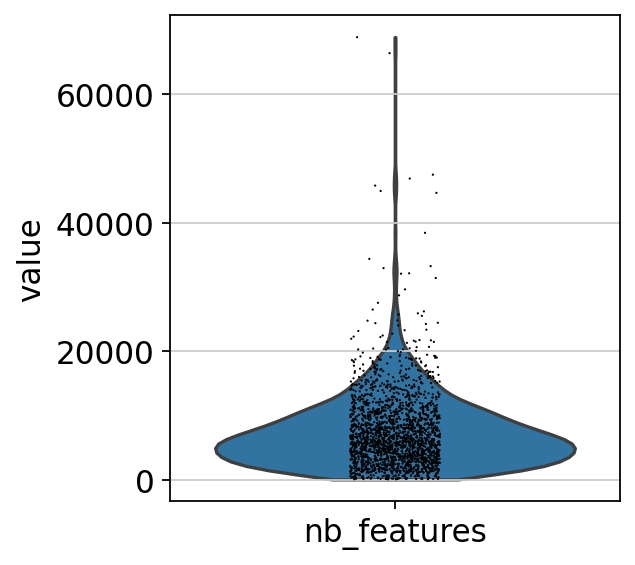

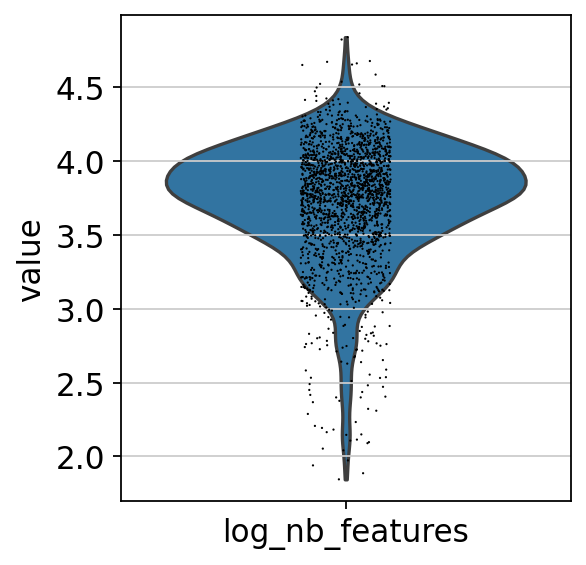

In [20]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

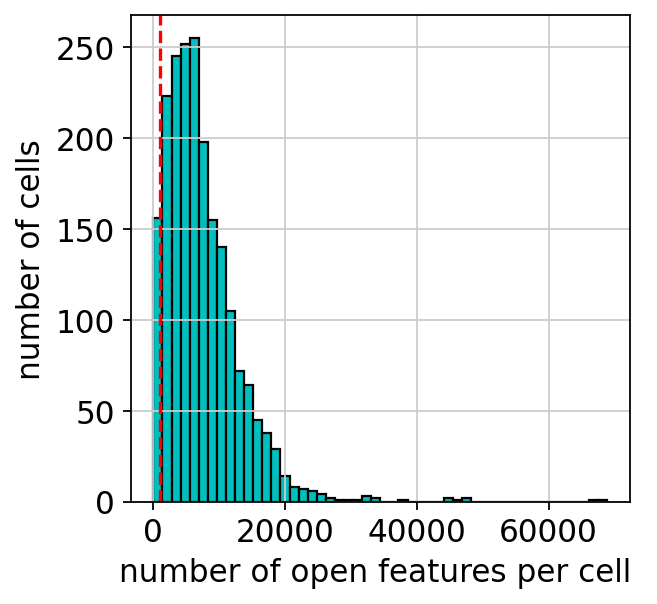

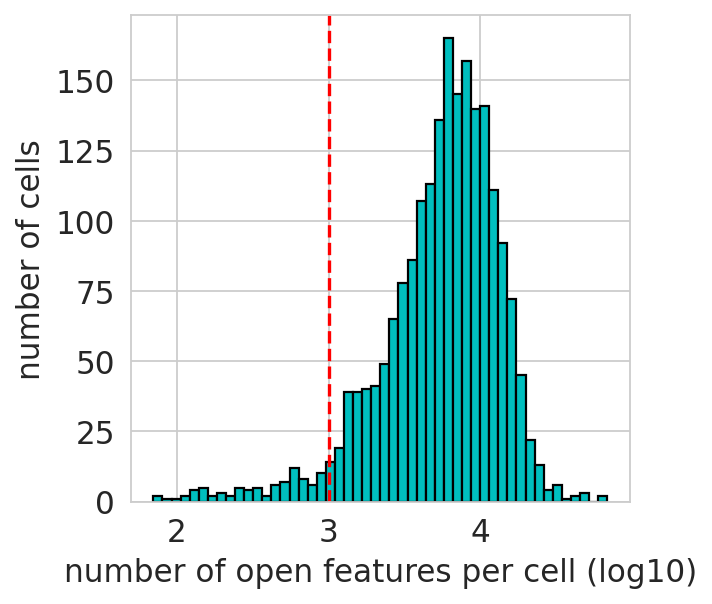

In [21]:
# set a minimum number of cells to keep 
min_features = 1000

epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=min_features, save='Buenrostro_bulk_peaks_coverage_cells.png')
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=min_features, save='Buenrostro_bulk_peaks_coverage_cells_log10.png')

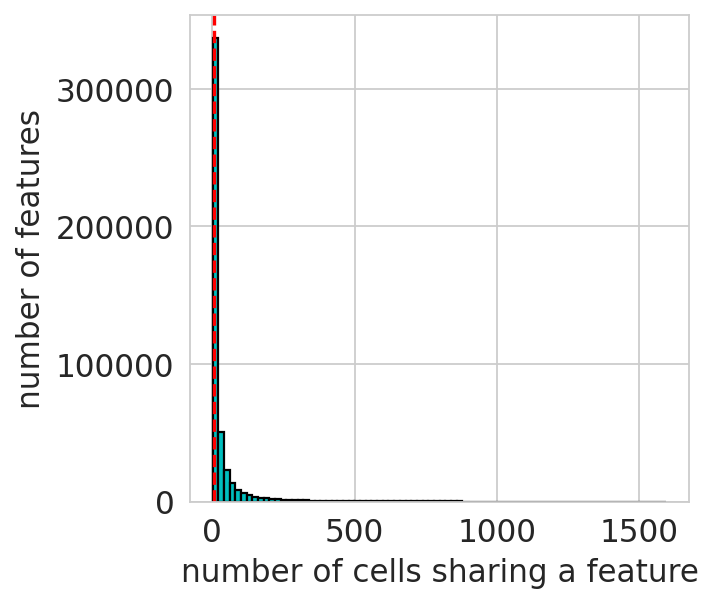

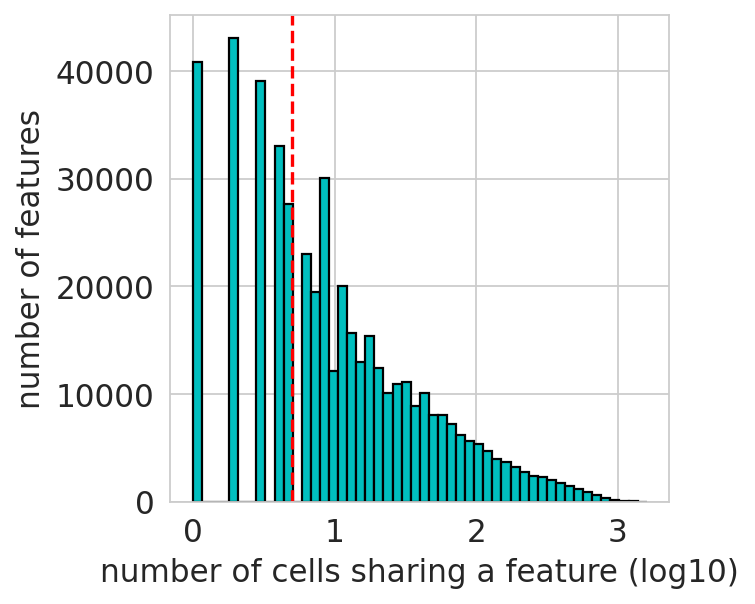

In [22]:
# minimum number of cells sharing a feature
min_cells = 5
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells, save='Buenrostro_bulk_peaks_coverage_peaks.png')
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells, save='Buenrostro_bulk_peaks_coverage_peaks_log10.png')

## Actually proceed to filter the cells and peaks based on the QC plots

In [23]:
min_features = 1000
epi.pp.filter_cells(adata, min_features=min_features)
adata

AnnData object with n_obs × n_vars = 1945 × 467226
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'transcript_annotation', 'n_cells', 'commonness'

In [24]:
min_cells = 5
epi.pp.filter_features(adata, min_cells=min_cells)
adata

AnnData object with n_obs × n_vars = 1945 × 311035
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'transcript_annotation', 'n_cells', 'commonness'

## Looking at the QC plots after filtering

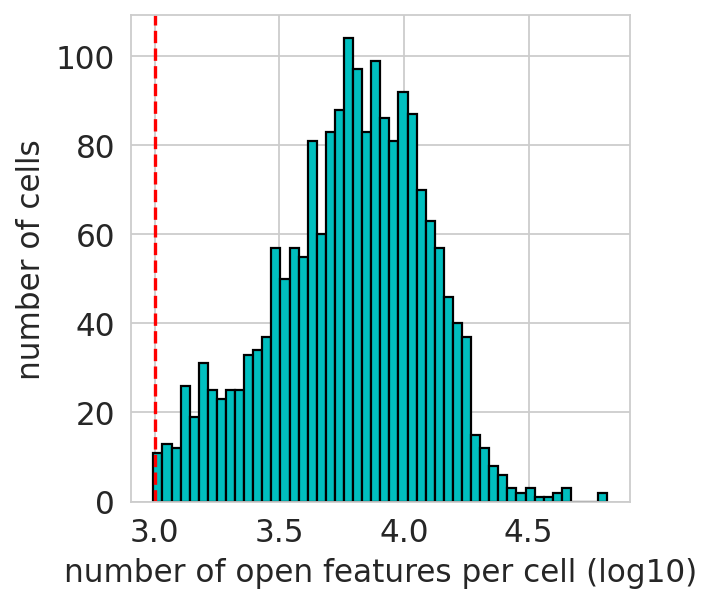

In [25]:
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=min_features)

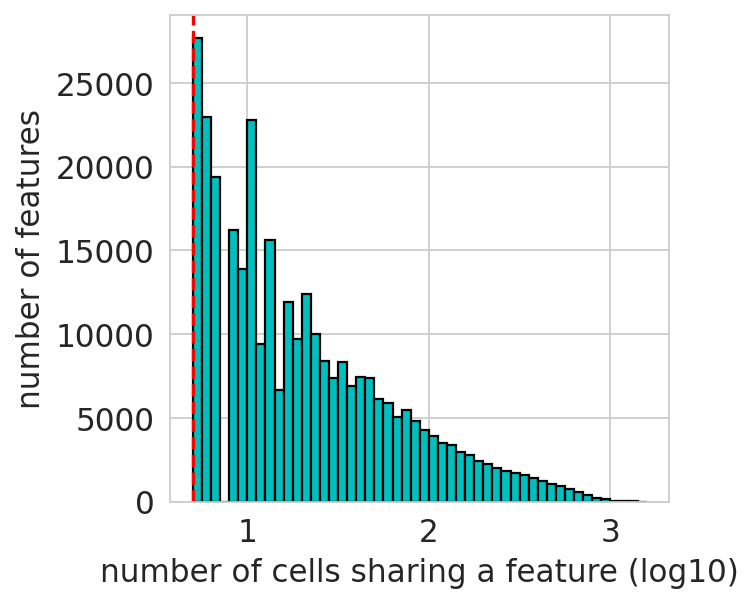

In [26]:
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=min_cells)

## Identifying the most variable features

We aim to select a cuttof after the elbow.

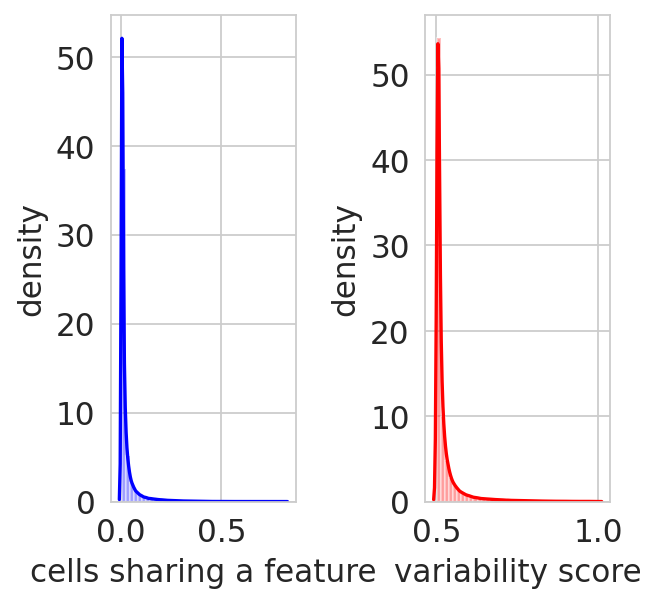

In [27]:
epi.pp.cal_var(adata)

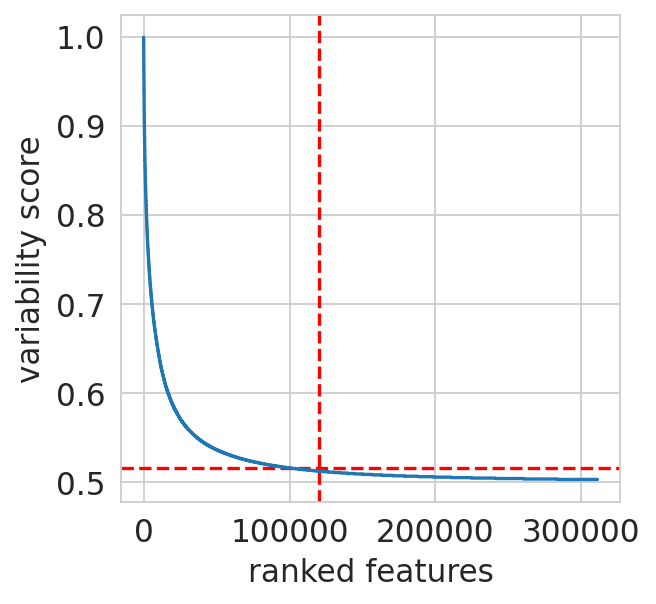

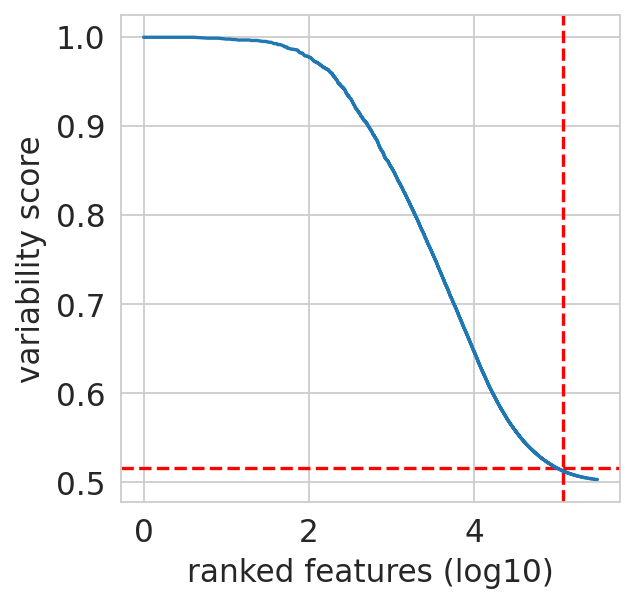

In [28]:
min_score_value = 0.515
nb_feature_selected = 120000
epi.pl.variability_features(adata,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix.png')

epi.pl.variability_features(adata,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix_log10.png')

In [29]:
# save the current matrix in the raw layer
adata.raw = adata

In [30]:
# create a new AnnData containing only the most variable features
adata = epi.pp.select_var_feature(adata,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

In [31]:
adata

View of AnnData object with n_obs × n_vars = 1945 × 122511
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'transcript_annotation', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

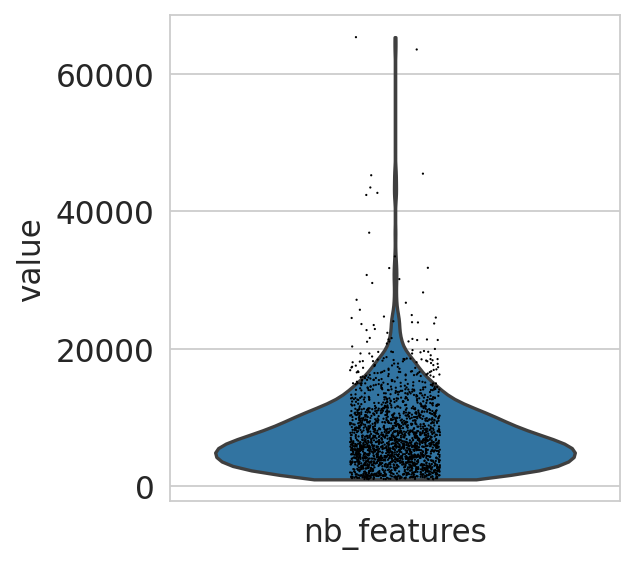

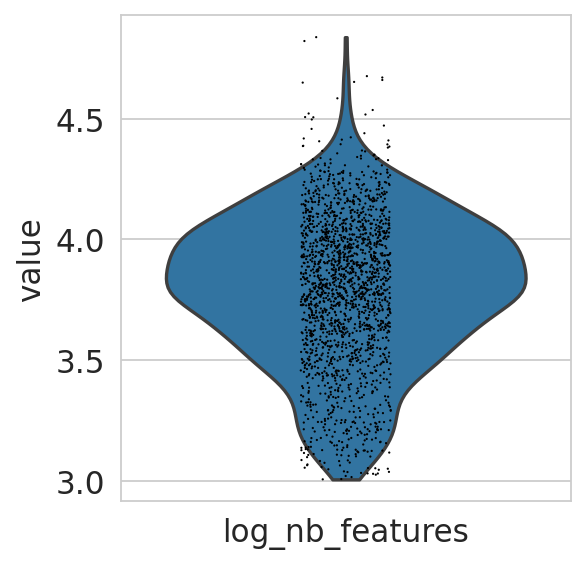

In [32]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

In [33]:
adata

View of AnnData object with n_obs × n_vars = 1945 × 122511
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'transcript_annotation', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [34]:
epi.pp.filter_cells(adata, min_features=2000)
epi.pp.filter_cells(adata, max_features=25000)

Trying to set attribute `.obs` of view, copying.


In [35]:
adata

AnnData object with n_obs × n_vars = 1722 × 122511
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'transcript_annotation', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

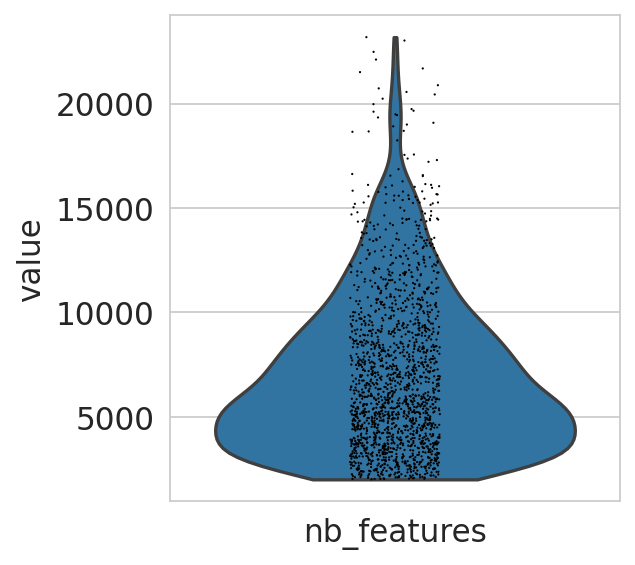

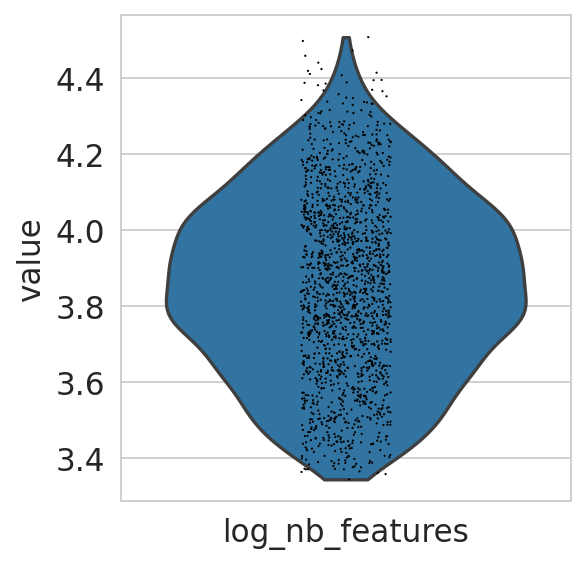

In [36]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

## We next use scOpen for dimensionality reduction

In [37]:
from scopen.Main import scopen_dr

In [38]:
adata.obsm['X_pca'] = np.transpose(scopen_dr(np.transpose(adata.X))) 

07/21/2021 21:59:10, running tf-idf transformation...
07/21/2021 21:59:24, violation:  1.00000000
07/21/2021 21:59:25, violation:  0.23809547
07/21/2021 21:59:25, violation:  0.15862548
07/21/2021 21:59:26, violation:  0.10376727
07/21/2021 21:59:26, violation:  0.06349803
07/21/2021 21:59:26, violation:  0.04762651
07/21/2021 21:59:27, violation:  0.04229391
07/21/2021 21:59:27, violation:  0.03723540
07/21/2021 21:59:28, violation:  0.03254635
07/21/2021 21:59:28, violation:  0.02844828
07/21/2021 21:59:28, violation:  0.02518969
07/21/2021 21:59:29, violation:  0.02276936
07/21/2021 21:59:29, violation:  0.02096878
07/21/2021 21:59:30, violation:  0.01953172
07/21/2021 21:59:30, violation:  0.01826928
07/21/2021 21:59:30, violation:  0.01709340
07/21/2021 21:59:31, violation:  0.01597418
07/21/2021 21:59:31, violation:  0.01491398
07/21/2021 21:59:32, violation:  0.01391376
07/21/2021 21:59:32, violation:  0.01298998
07/21/2021 21:59:33, violation:  0.01215548
07/21/2021 21:59:33, v

In [39]:
epi.pp.neighbors(adata)

In [40]:
epi.tl.umap(adata)

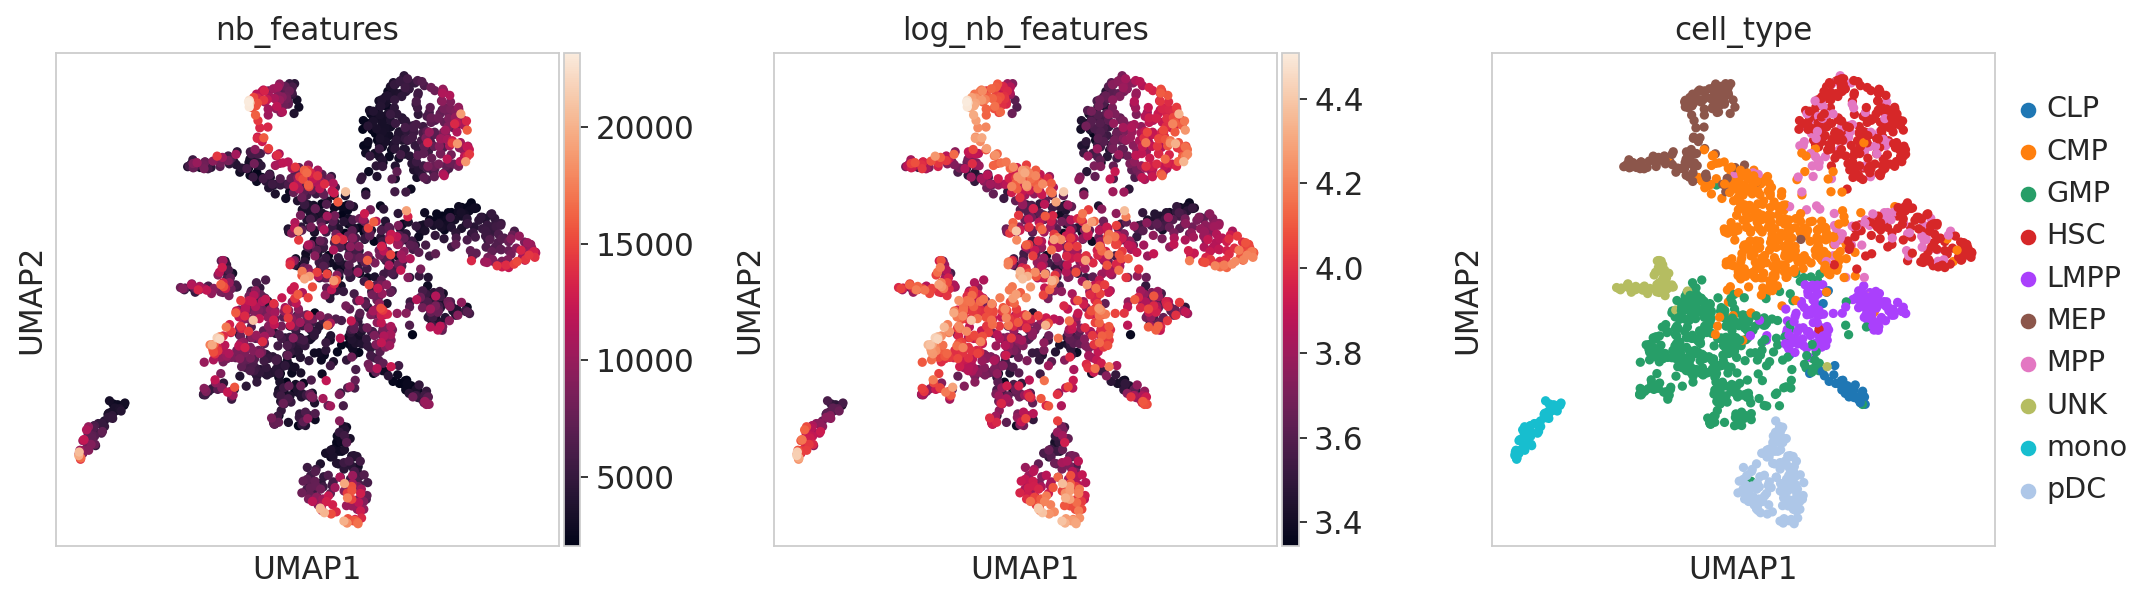

In [41]:
epi.pl.umap(adata, color=['nb_features', 'log_nb_features', 'cell_type'], wspace=0.3)

## Cell clustering

### 1. Louvain clustering

In [42]:
epi.tl.louvain(adata)

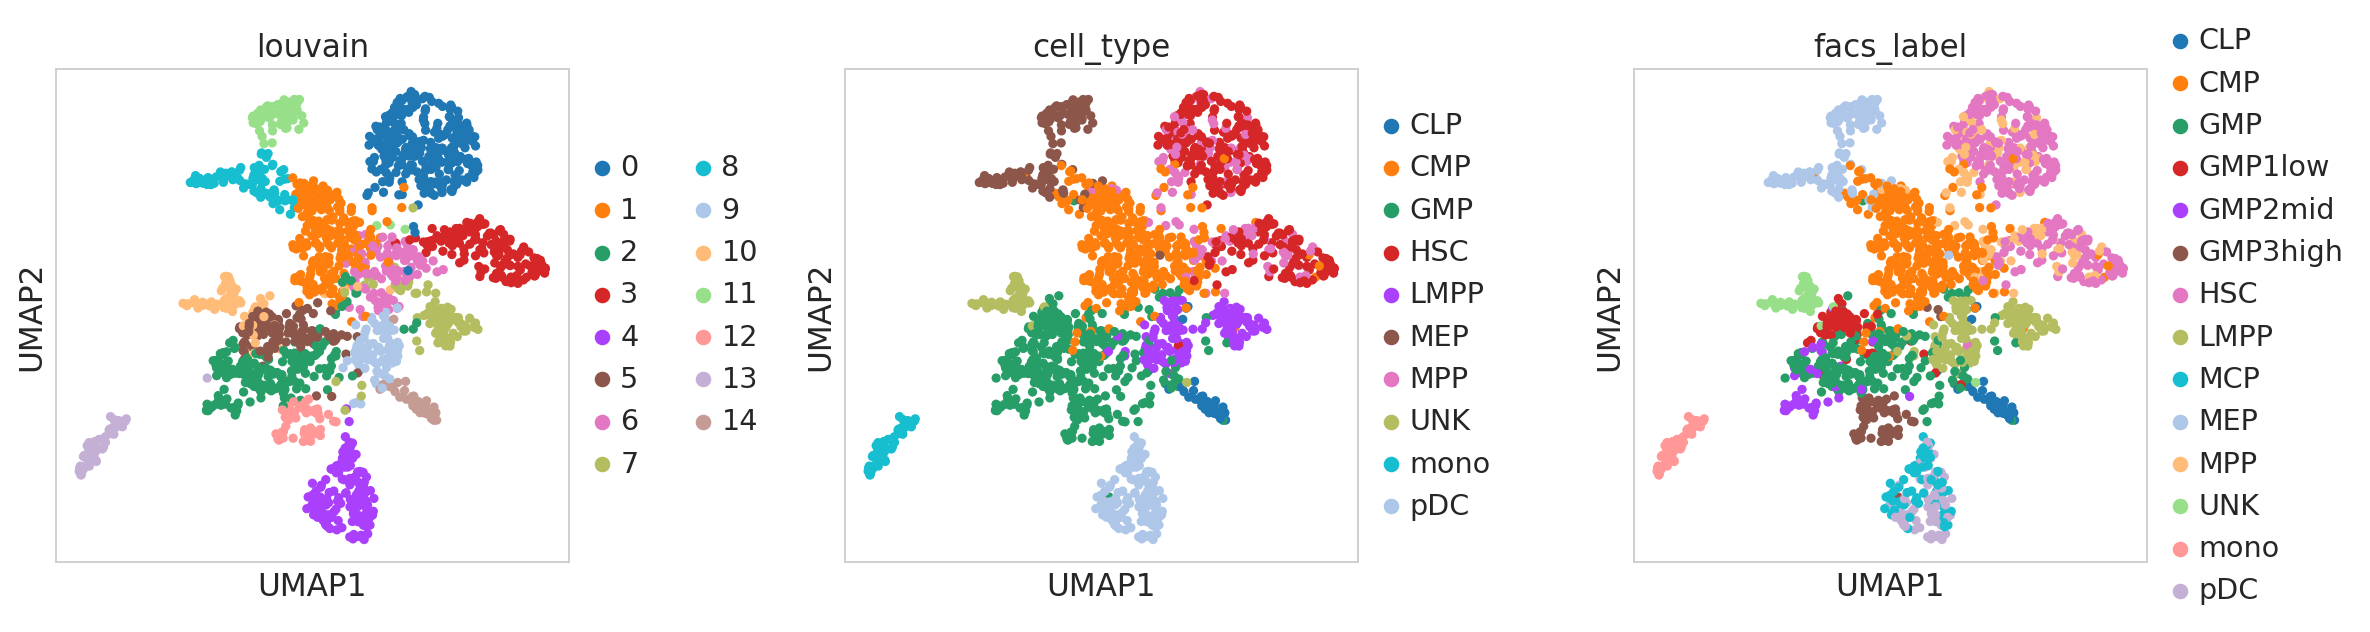

In [43]:
epi.pl.umap(adata, color=['louvain', 'cell_type', 'facs_label'], wspace=0.4)

In [44]:
epi.tl.getNClusters(adata, n_cluster=14)

step 0
got 17 at resolution 1.5
step 1
got 12 at resolution 0.75
step 2
got 15 at resolution 1.125
step 3
got 14 at resolution 0.9375


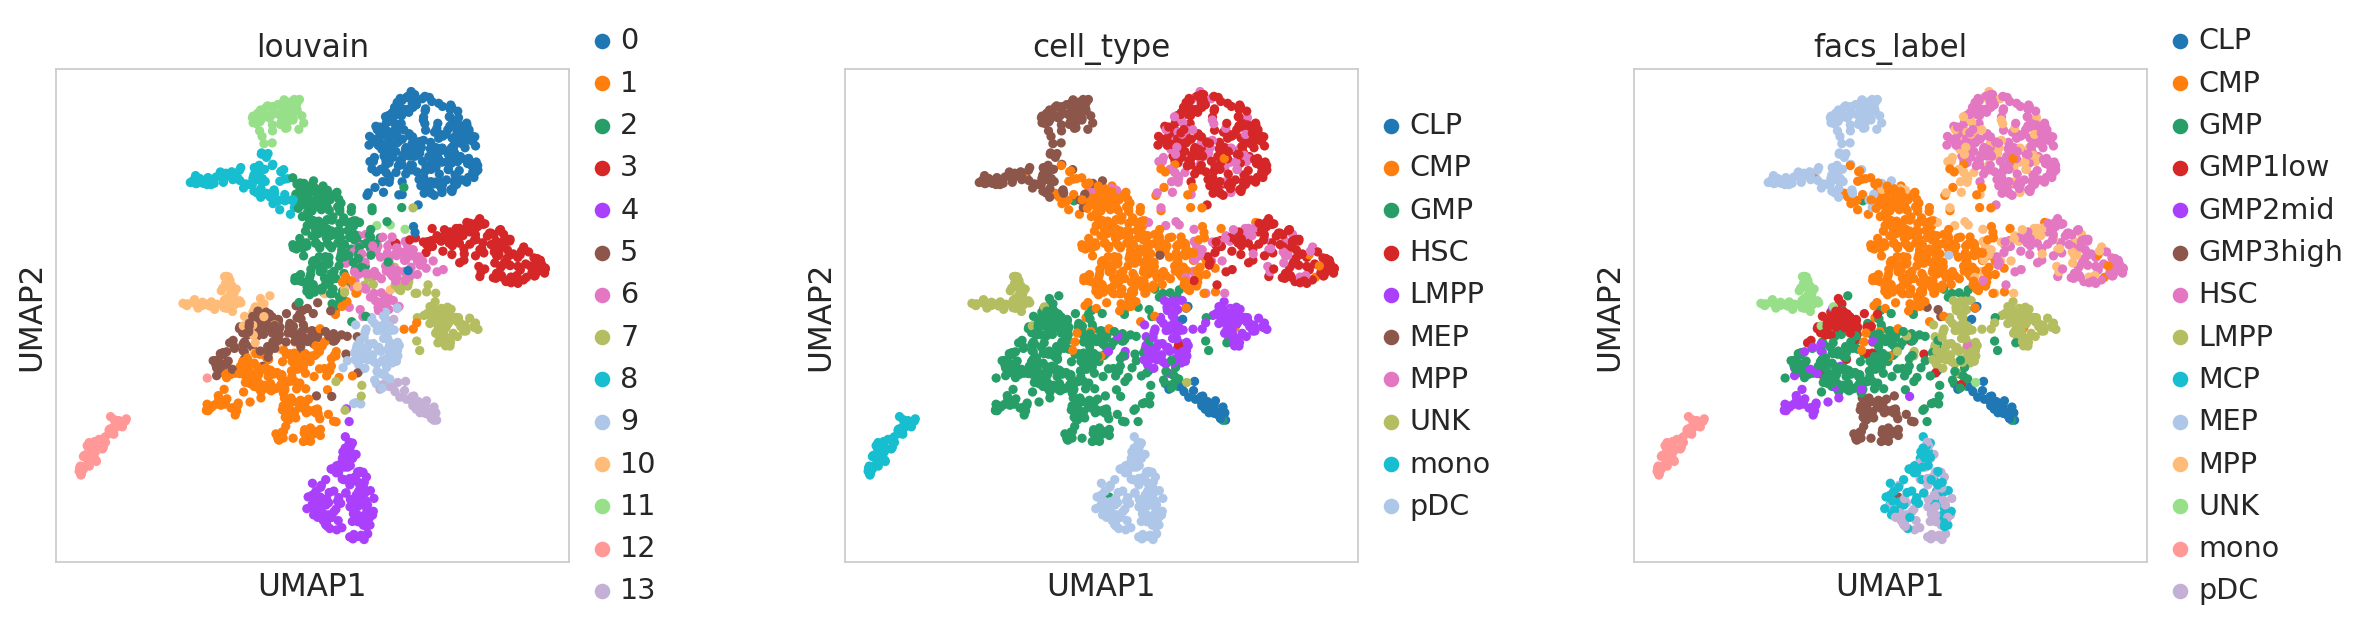

In [45]:
epi.pl.umap(adata, color=['louvain', 'cell_type', 'facs_label'], wspace=0.4)

### 2. kmeans clustering

In [46]:
epi.tl.kmeans(adata, num_clusters=14)

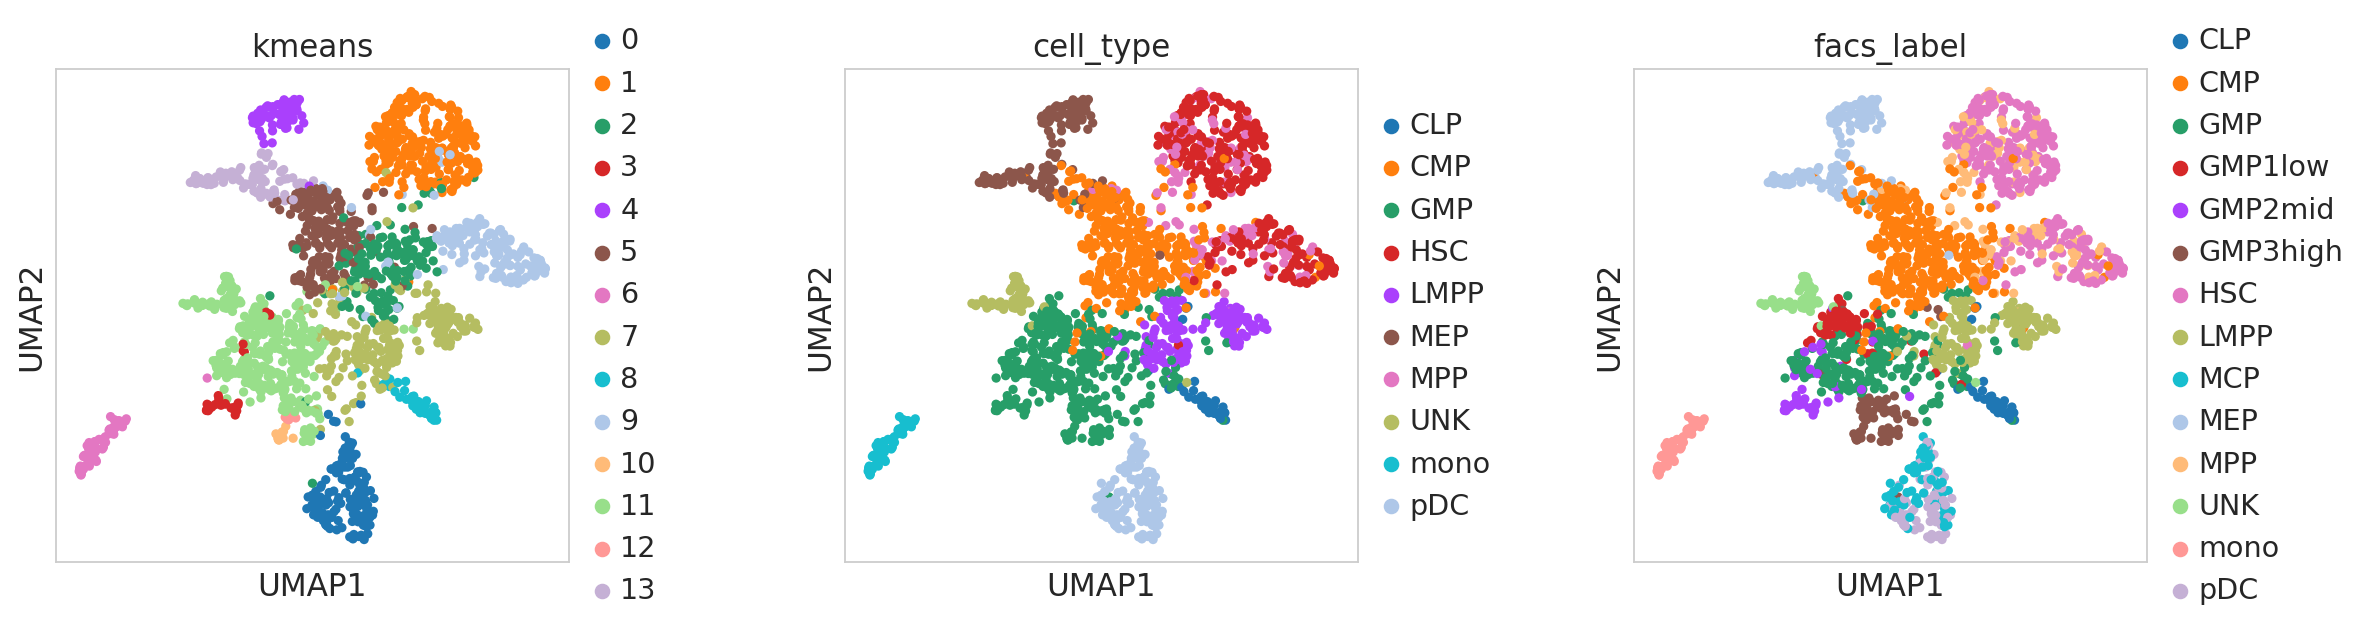

In [47]:
epi.pl.umap(adata, color=['kmeans', 'cell_type', 'facs_label'], wspace=0.4)

### 3. hierarchical clustering

In [48]:
epi.tl.hc(adata, num_clusters=14)

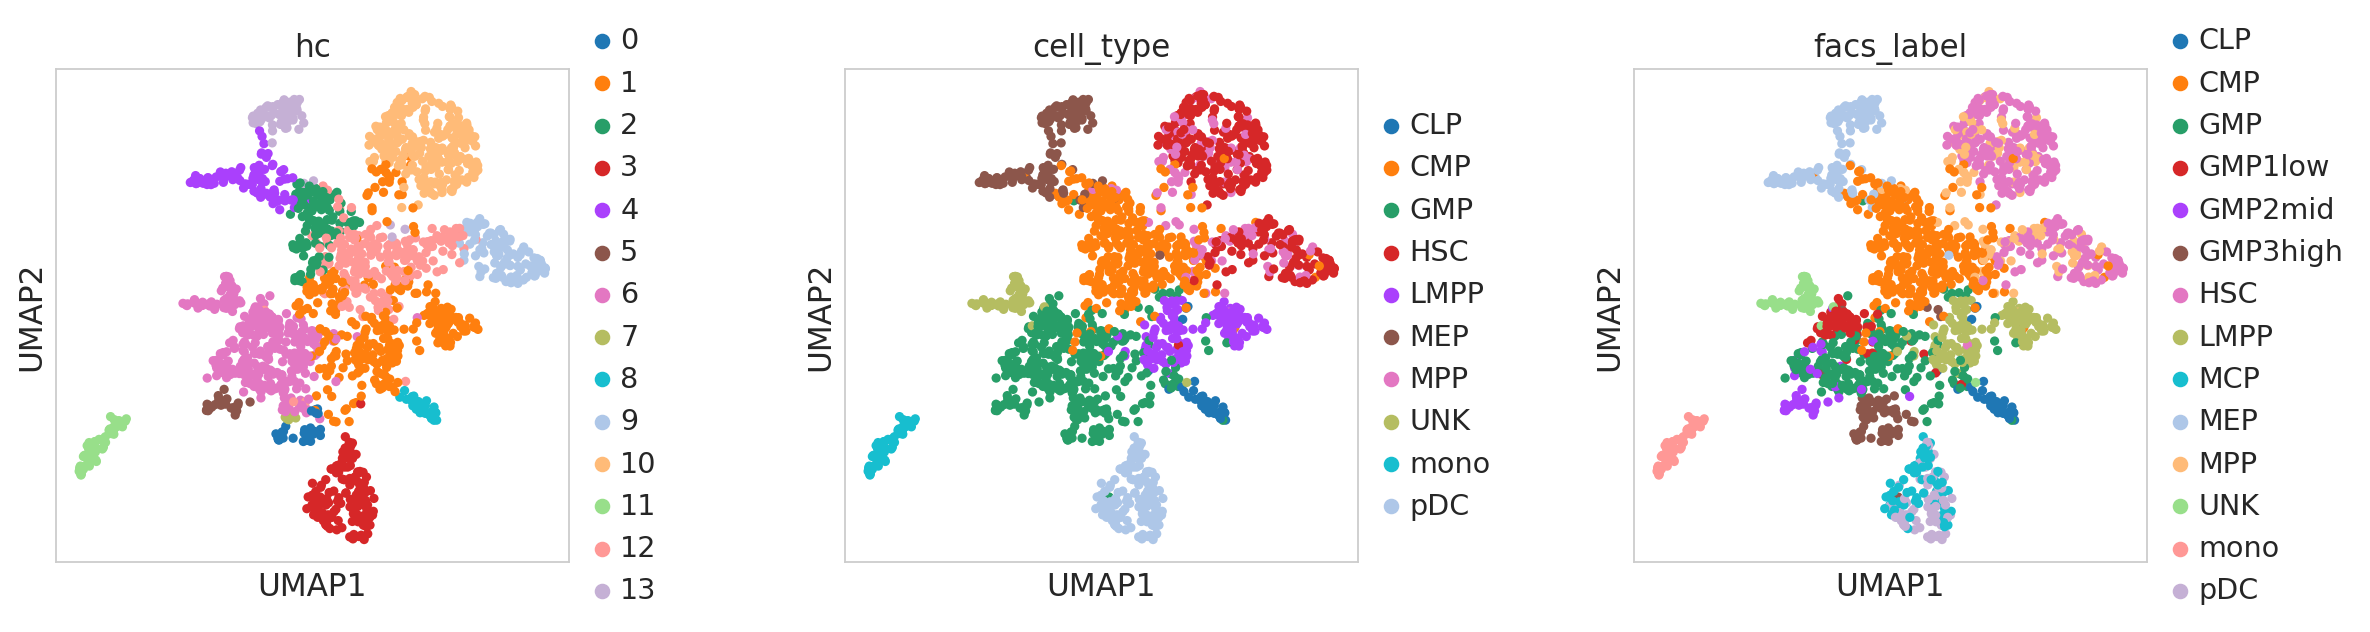

In [49]:
epi.pl.umap(adata, color=['hc', 'cell_type', 'facs_label'], wspace=0.4)

### 4. leiden clustering

In [50]:
epi.tl.leiden(adata)

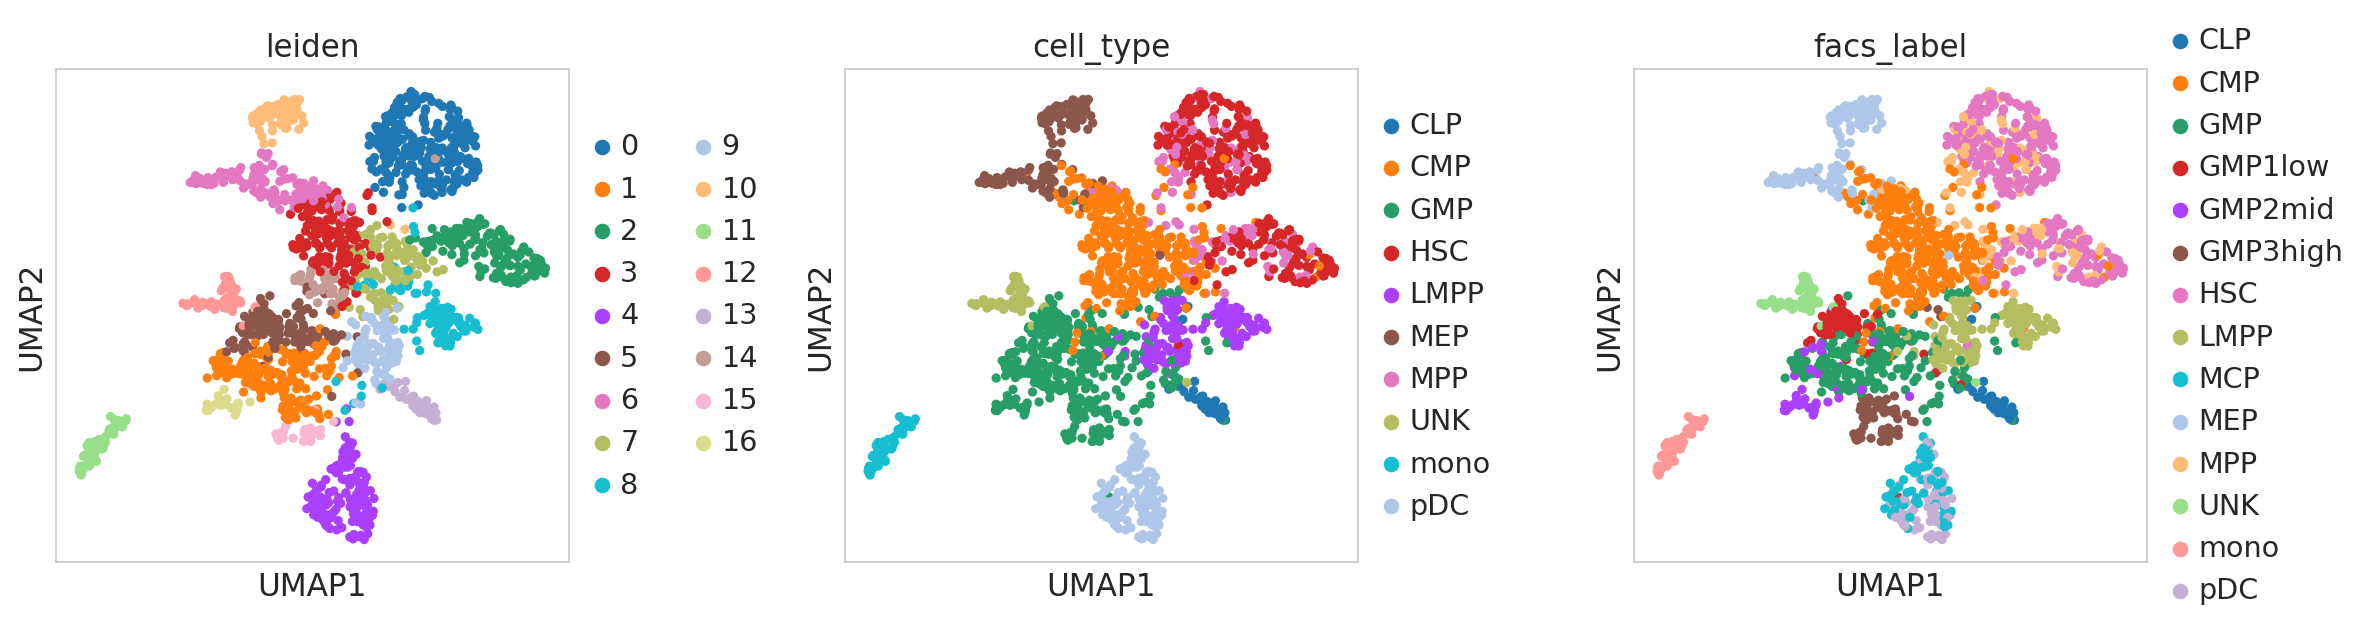

In [51]:
epi.pl.umap(adata, color=['leiden', 'cell_type', 'facs_label'], wspace=0.4)

In [52]:
epi.tl.getNClusters(adata, n_cluster=14, method='leiden')

step 0
got 18 at resolution 1.5
step 1
got 13 at resolution 0.75
step 2
got 16 at resolution 1.125
step 3
got 16 at resolution 0.9375
step 4
got 13 at resolution 0.84375
step 5
got 15 at resolution 0.890625
step 6
got 13 at resolution 0.8671875
step 7
got 15 at resolution 0.87890625
step 8
got 15 at resolution 0.873046875
step 9
got 15 at resolution 0.8701171875
step 10
got 13 at resolution 0.86865234375
step 11
got 13 at resolution 0.869384765625
step 12
got 15 at resolution 0.8697509765625
step 13
got 15 at resolution 0.86956787109375
step 14
got 15 at resolution 0.869476318359375
step 15
got 13 at resolution 0.8694305419921875
step 16
got 13 at resolution 0.8694534301757812
step 17
got 15 at resolution 0.8694648742675781
step 18
got 15 at resolution 0.8694591522216797
step 19
got 13 at resolution 0.8694562911987305


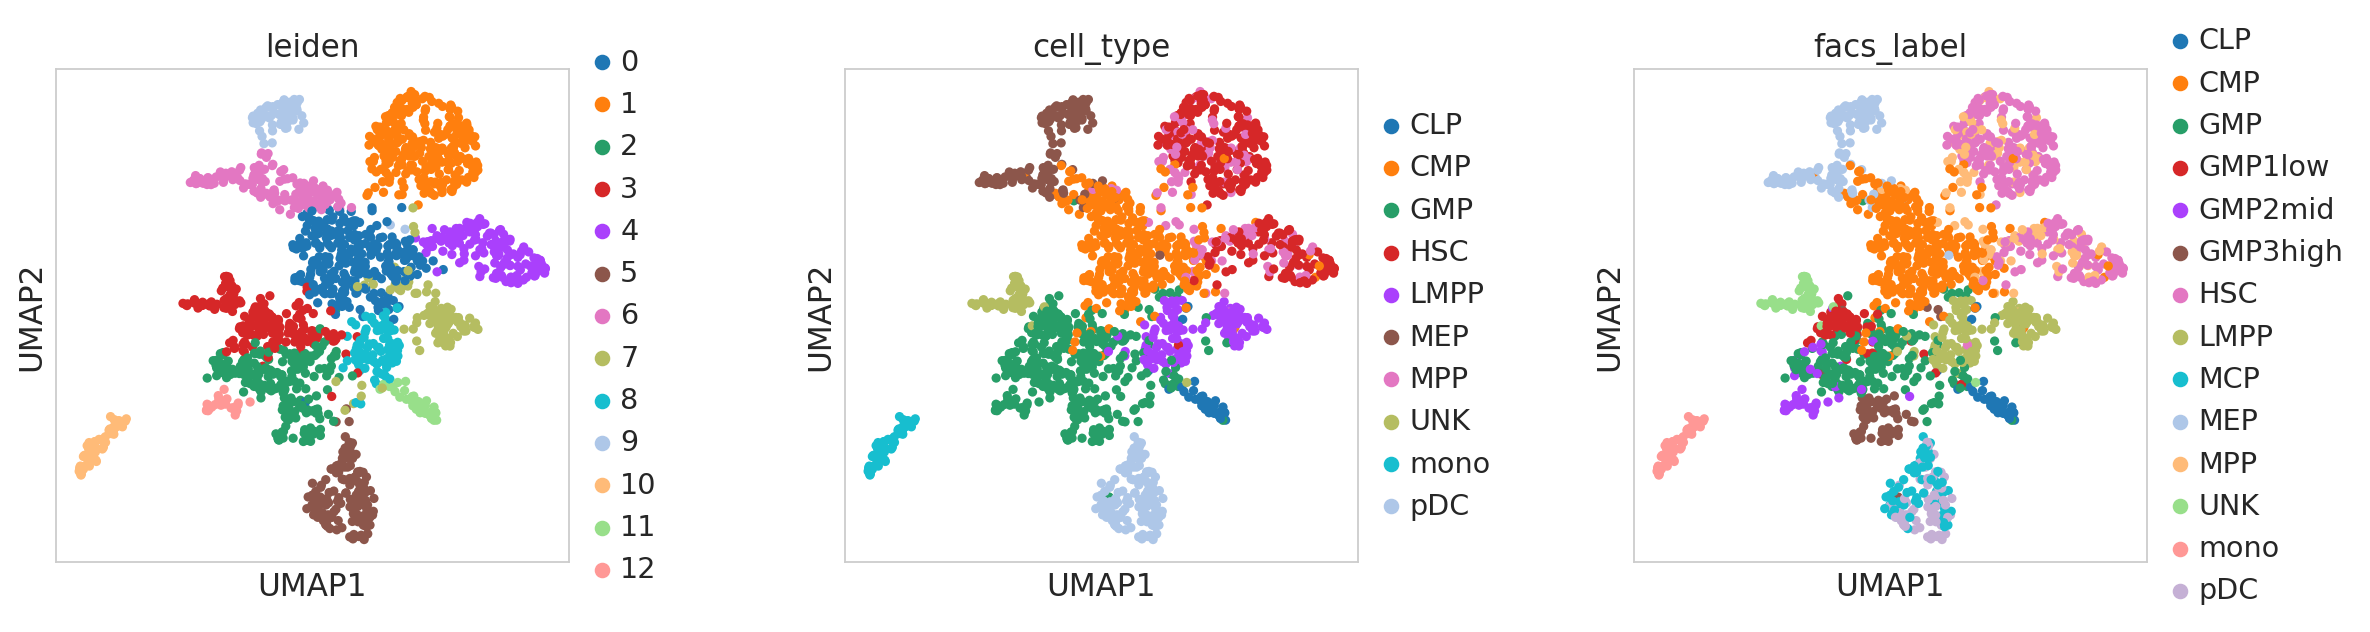

In [53]:
epi.pl.umap(adata, color=['leiden', 'cell_type', 'facs_label'], wspace=0.4)

### 5. Comparison and Adjusted Rand Index (ARI)

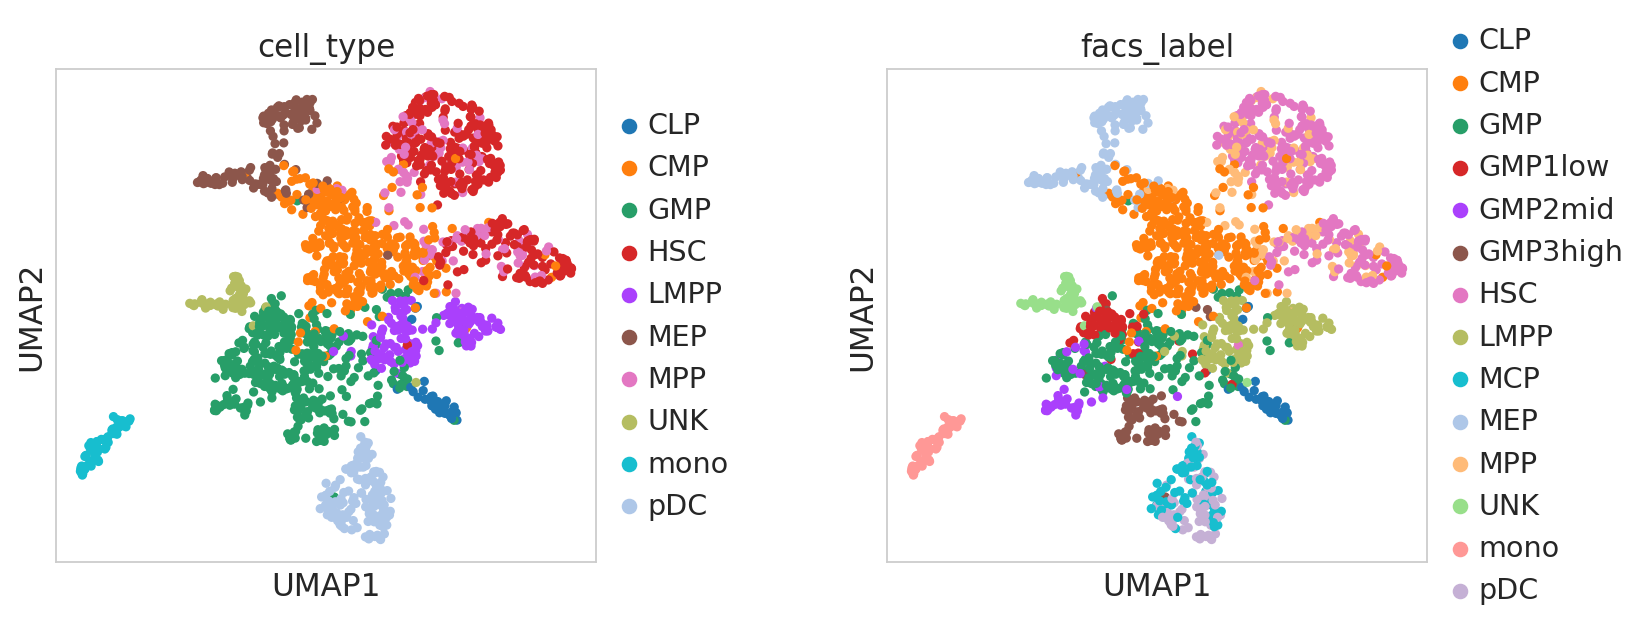

In [54]:
# True labels
epi.pl.umap(adata, color=['cell_type', 'facs_label'], wspace=0.4)

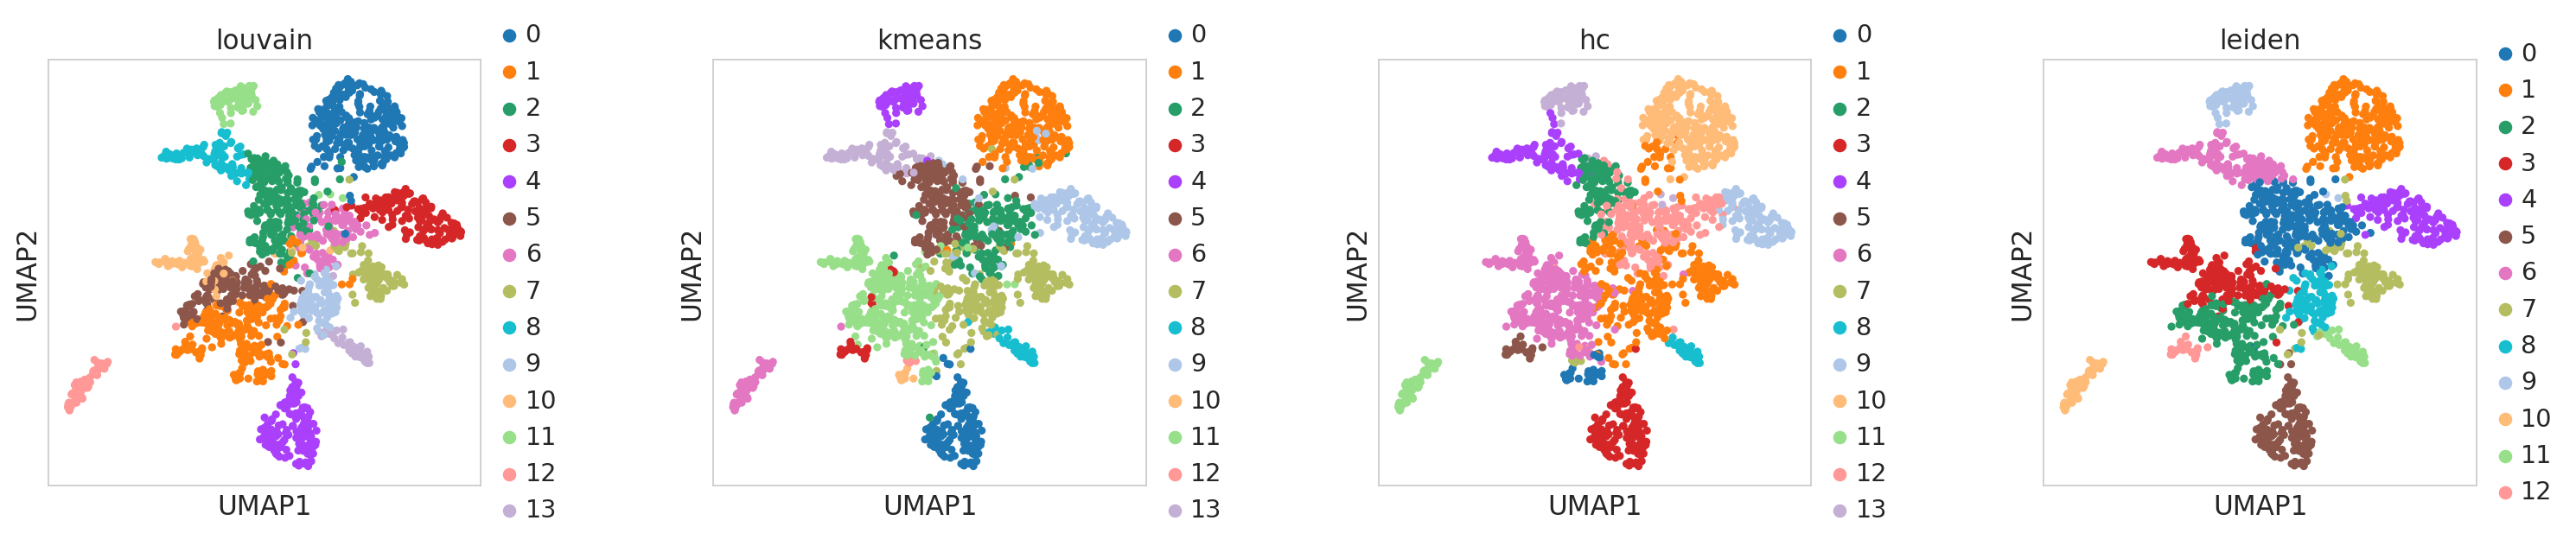

In [55]:
# Clusters
epi.pl.umap(adata, color=['louvain', 'kmeans', 'hc', 'leiden'], wspace=0.4)

#### A few metrics to compare the quality of the different clusterings.
For all these methods. The best value possible is 1.

1) Compute the Adjusted Rand Index for the different clustering to determine which one perform best. It computes a similarity measure between two clusterings (predicted and true labels)by counting cells that are assigned in the same or different clusters between the two clusterings.

In [56]:
print('louvain:\t', epi.tl.ARI(adata, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.ARI(adata, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.ARI(adata, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.ARI(adata, 'leiden', 'cell_type'))

louvain:	 0.5026830907128316
kmeans:	 0.47398964189429343
hc:	 0.4443018268622743
leiden:	 0.494350768736209


2) Compute the Homogeneity score. The score is higher when the different clusters contain only cells with the same ground truth label

In [57]:
print('louvain:\t', epi.tl.homogeneity(adata, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.homogeneity(adata, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.homogeneity(adata, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.homogeneity(adata, 'leiden', 'cell_type'))

louvain:	 0.620855120000249
kmeans:	 0.607717394358658
hc:	 0.6095090801233856
leiden:	 0.6247759815798529


3) Compute the Adjusted Mutual Information, it is measure of the similarity between two labels of the same data, while accounting for chance (the Mutual information is generally higher for two set of labels with a large number of clusters)

In [58]:
print('louvain:\t', epi.tl.AMI(adata, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.AMI(adata, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.AMI(adata, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.AMI(adata, 'leiden', 'cell_type'))

louvain:	 0.6756279946014332
kmeans:	 0.6371966070741591
hc:	 0.6380117508290446
leiden:	 0.664802449730221


In [59]:
## Save the processed Anndata

In [60]:
adata.write(results_file)

## Differential chromatin analysis

In [61]:
adata = ad.read(results_file)
adata

AnnData object with n_obs × n_vars = 1722 × 122511
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type', 'nb_features', 'log_nb_features', 'louvain', 'kmeans', 'hc', 'leiden'
    var: 'transcript_annotation', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'facs_label_colors', 'hc_colors', 'kmeans_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [62]:
epi.tl.rank_features(adata, 'louvain', omic='ATAC')

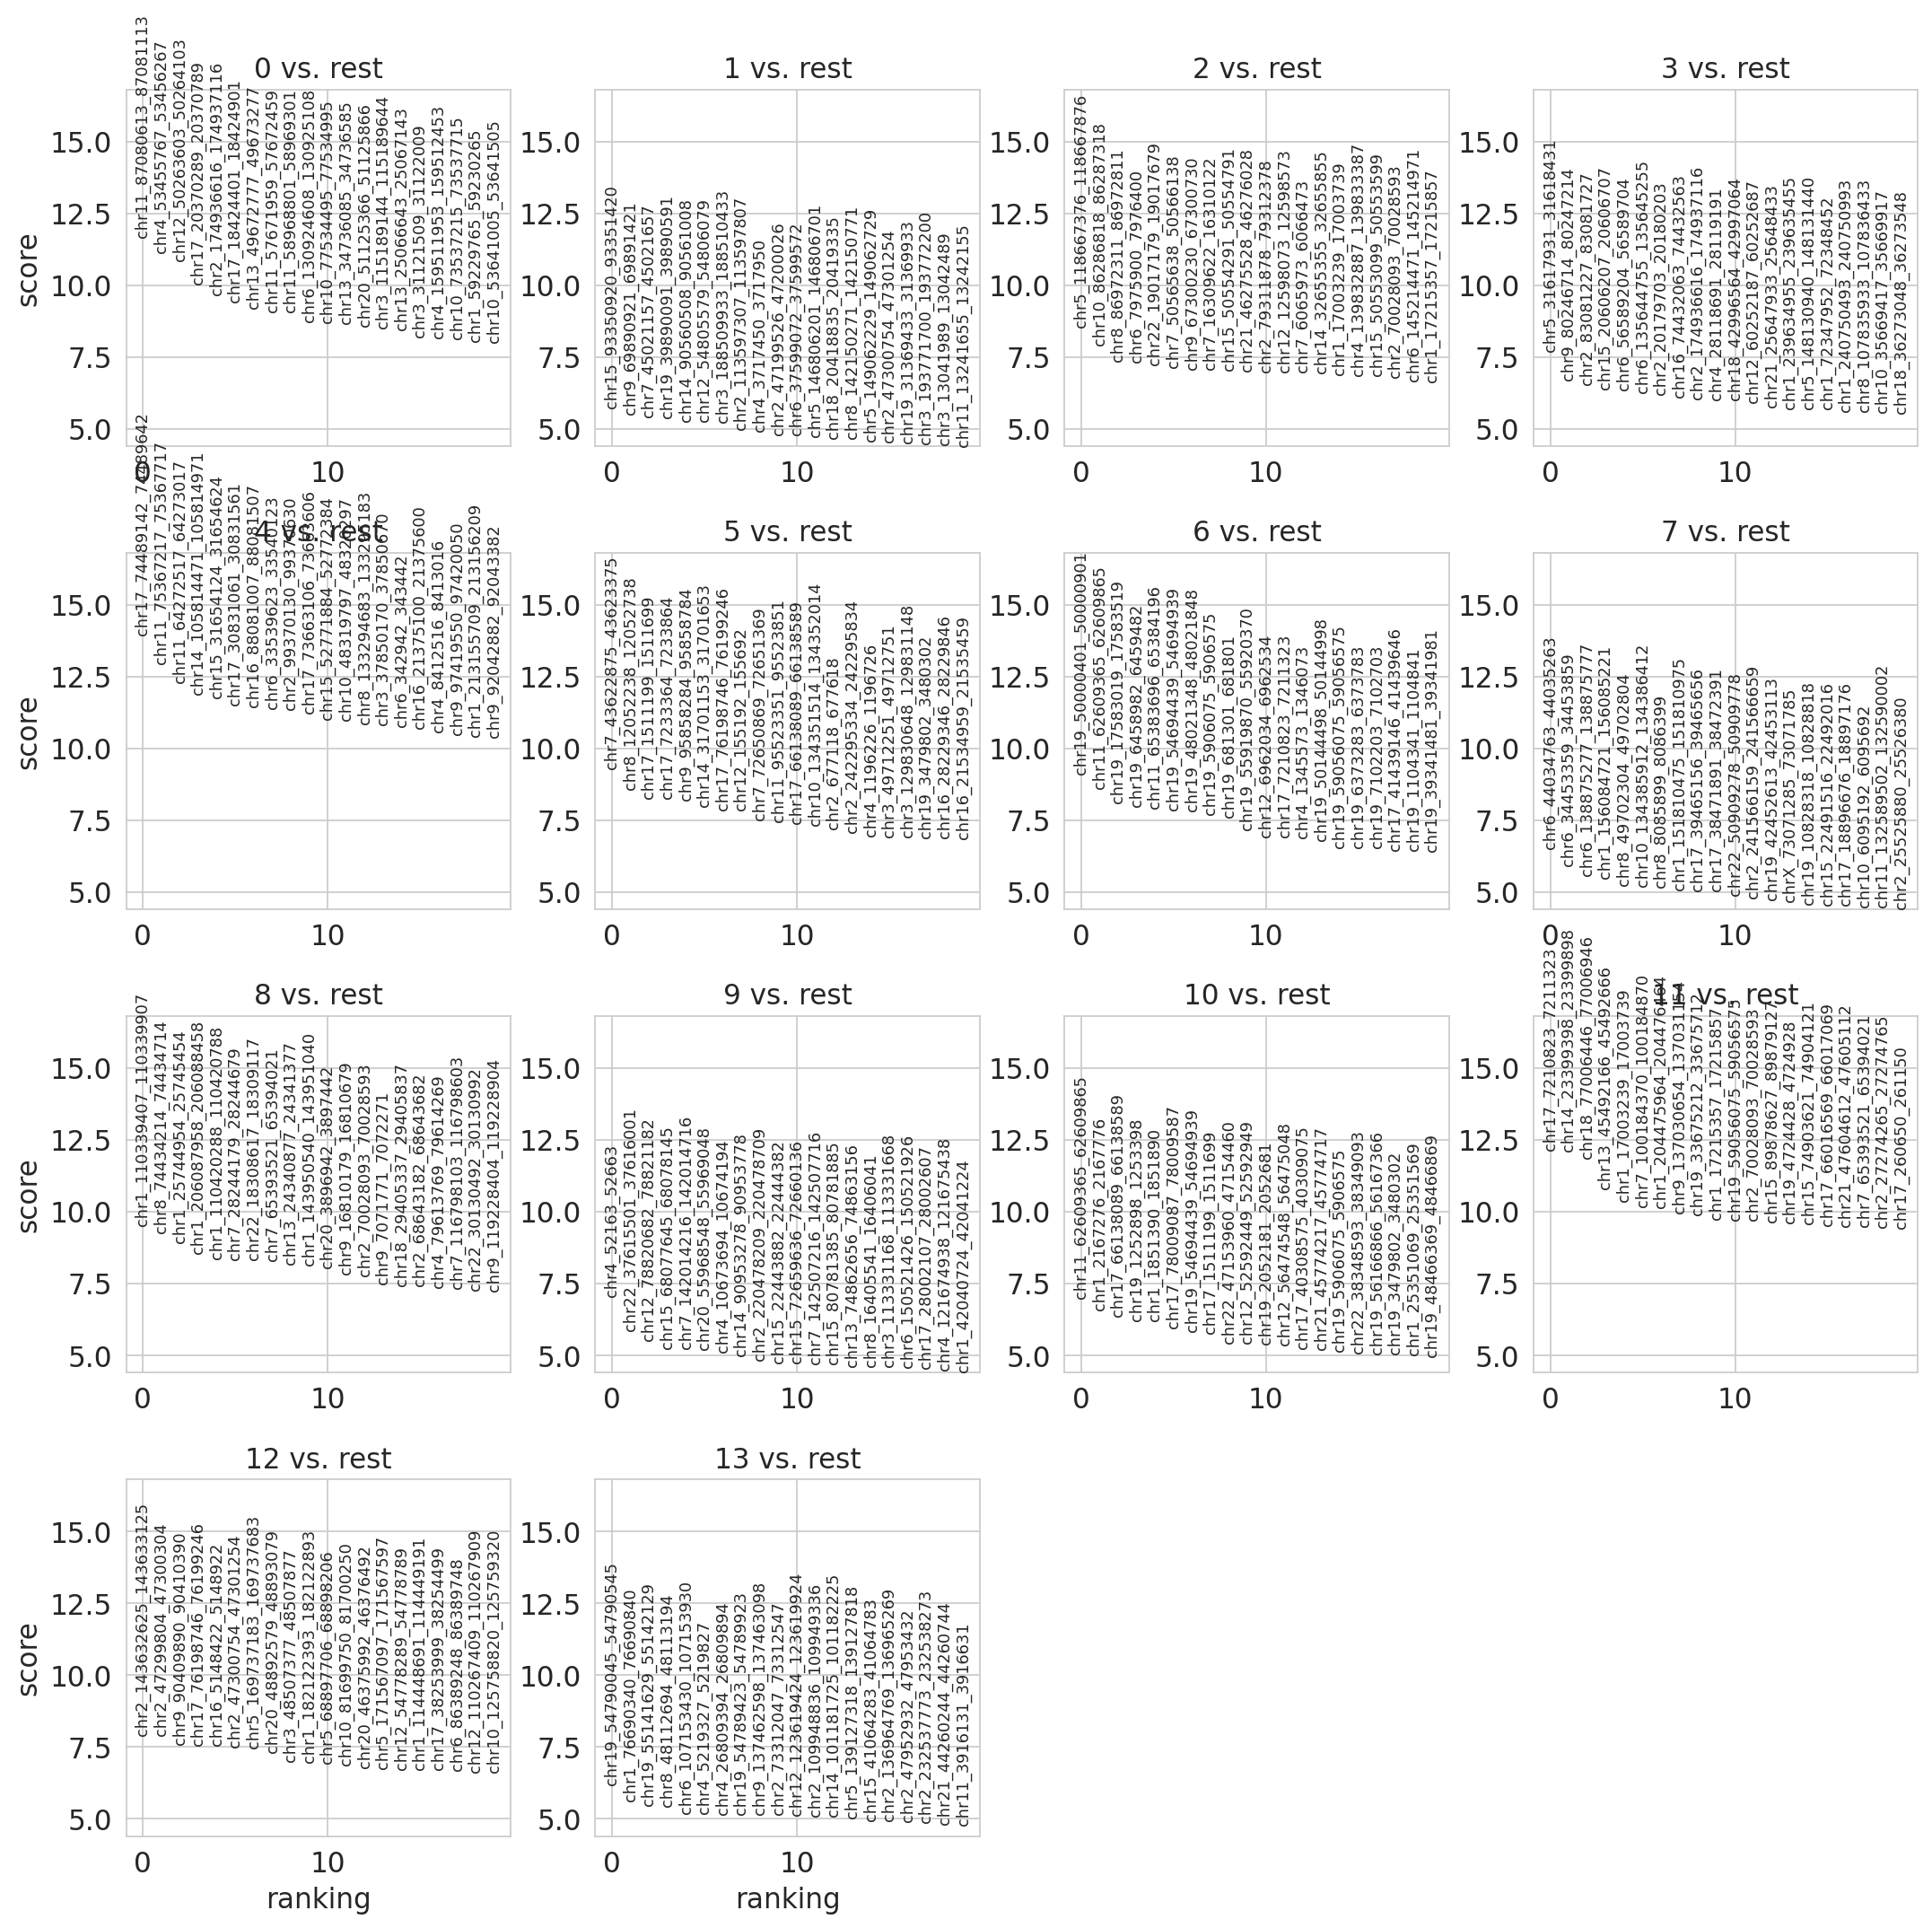

In [63]:
epi.pl.rank_feat_groups(adata)

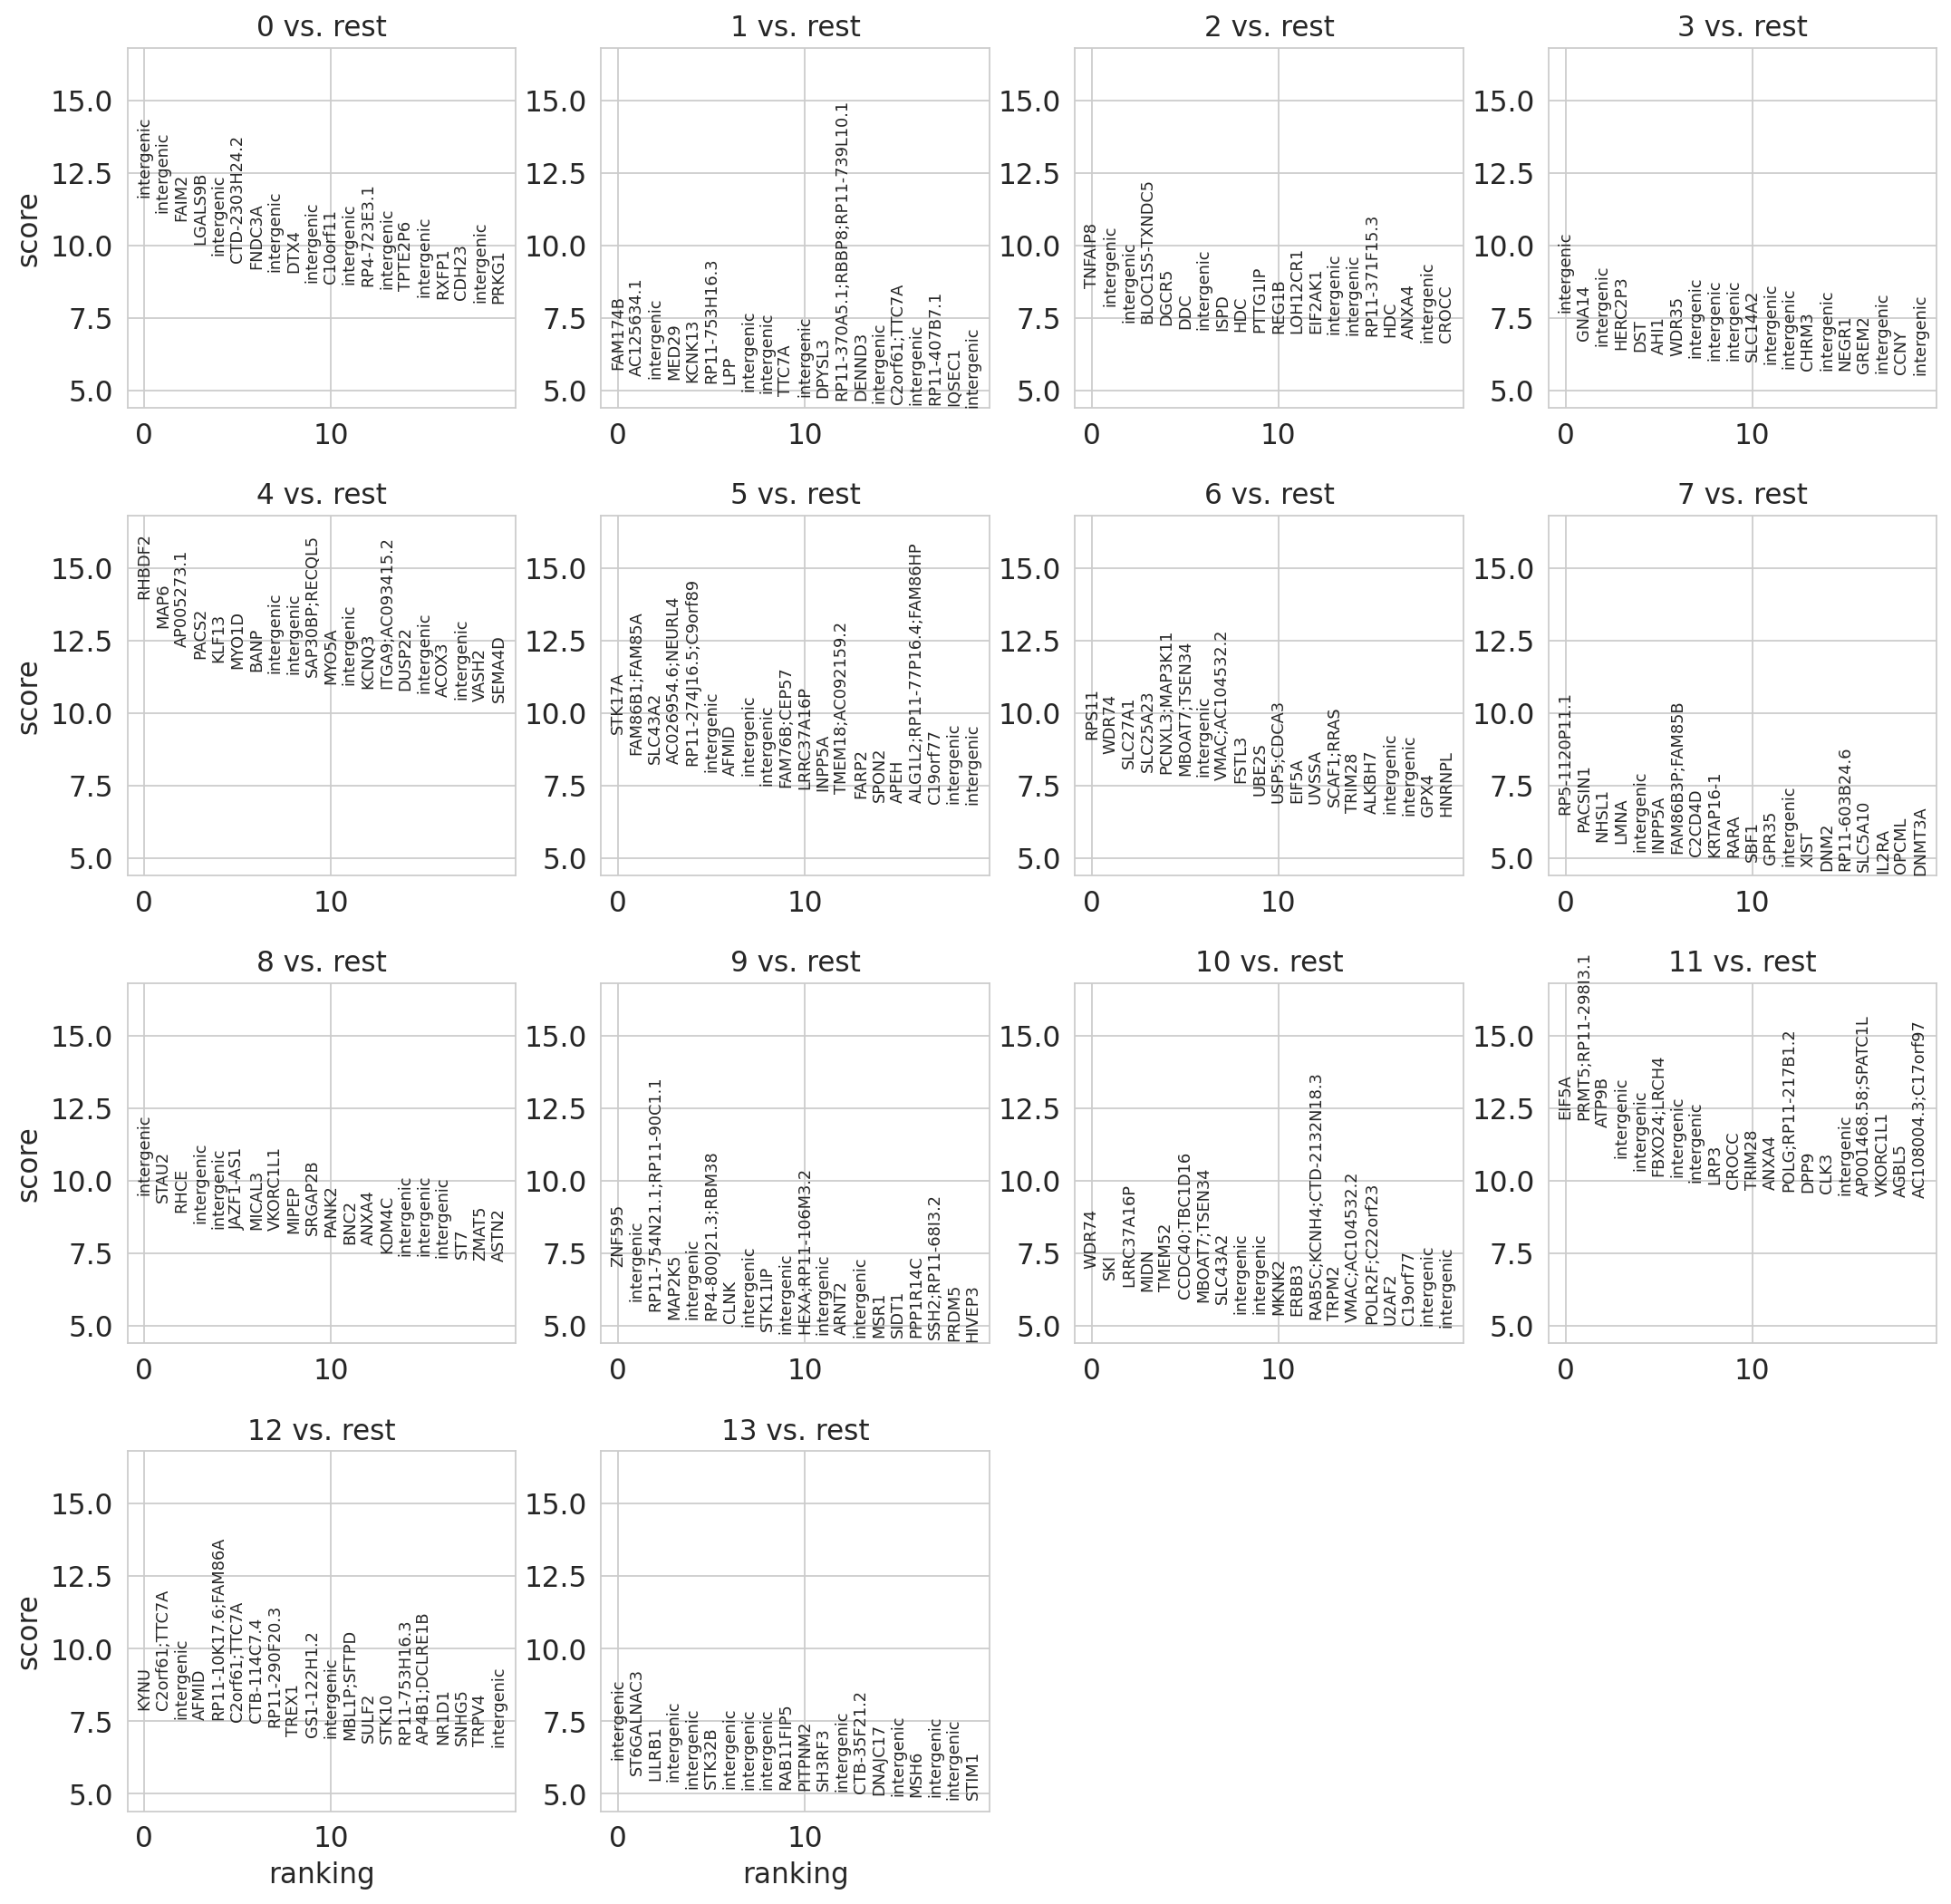

In [64]:
epi.pl.rank_feat_groups(adata, feature_symbols='transcript_annotation')

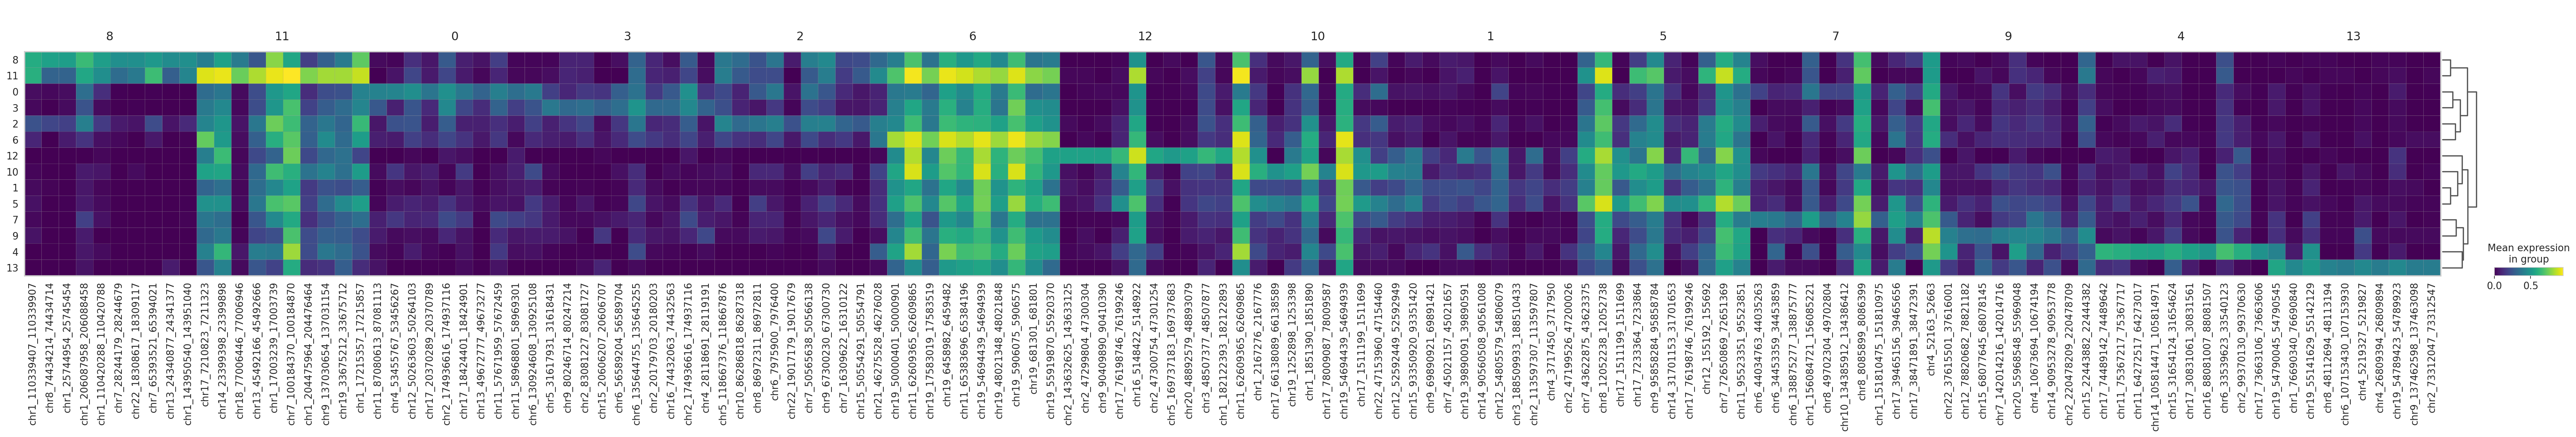

In [65]:
epi.pl.rank_feat_groups_matrixplot(adata)